## In this note book i will do the machine learning

In [43]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [44]:
os.getcwd()

'/Users/sebaselim/fraud-detection-project'

In [45]:
df=pd.read_csv(r'cleaned_fraud_data.csv')

In [46]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,mismatch_org,amount_ratio,mismatch_dest
0,CASH_OUT,158007.12,0.00,0.00,474016.32,1618631.97,0,1,1,1
1,CASH_OUT,457948.30,0.00,0.00,2720411.37,3178359.67,0,1,1,0
2,CASH_IN,153602.99,11160428.67,11314031.67,3274930.56,3121327.56,0,1,0,1
3,CASH_OUT,49555.14,10865.00,0.00,0.00,49555.14,0,1,1,0
4,CASH_OUT,29648.02,0.00,0.00,56933.09,86581.10,0,1,1,1


## <span style="color:pink"> -Preprocessig</span>

In [47]:
x= df.drop("isFraud", axis=1)
y= df["isFraud"]

# train , test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


# create a ColumnTransformer that applies one-hot encoding to 'type'
# and RobustScaler to the numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False, drop="first"), ['type']),
        ("scaler", RobustScaler(), ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])
    ],
    remainder="passthrough"
)




In [48]:
# tryin different models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

## <span style="color:pink"> -Cross Validation for compering models</span>

In [49]:
# Perform cross-validation to evaluate each model across multiple folds 
cv_results = {}

#pipeline 
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)), # to handle class imbalance
        ('model', model)
    ])

    scores = cross_validate(
        pipeline,
        x, y,
        cv=5,
        scoring='f1',
        return_train_score=True
    )

    cv_results[name] = {
        "CV_Train_F1": scores['train_score'].mean(),
        "CV_Test_F1": scores['test_score'].mean()
    }

cv_df = pd.DataFrame(cv_results).T
print(cv_df)

                    CV_Train_F1  CV_Test_F1
LogisticRegression     0.128355    0.127539
DecisionTree           1.000000    0.996459
RandomForest           1.000000    0.996459
XGBoost                0.992957    0.982420


Although Decision Tree and Random Forest achieved higher F1-scores their perfect training performance indicates potential overfitting XGBoost was selected due to its more balanced train and test performance suggesting better generalization.

## <span style="color:pink"> -Grid Search (Hyperparameter tuning)</span>

In [50]:
best_model = XGBClassifier(eval_metric='logloss', random_state=42)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', best_model)
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(x_train, y_train)



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=1.0; total time=   1.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=1.0; total time=   1.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=1.0; total time=   1.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.6s
[CV] END model__colsample_bytree

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.8, 1.0], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5, ...], 'model__n_estimators': [100, 200], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('onehot', ...), ('scaler', ...)]"


In [51]:
print("Best Params:", grid.best_params_)
print("Best CV F1 :", grid.best_score_)
best_pipeline = grid.best_estimator_


Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 1.0}
Best CV F1 : 0.9825568059240585


## <span style="color:pink"> -Final Training and Evaluation (Train/Test), confusion matrix</span>

{'Train F1': 0.9868421052631579, 'Test F1': 0.9911504424778761, 'Train Recall': 0.995575221238938, 'Test Recall': 1.0, 'Train Precision': 0.9782608695652174, 'Test Precision': 0.9824561403508771, 'Train Accuracy': 0.9999624997656236, 'Test Accuracy': 0.999975}


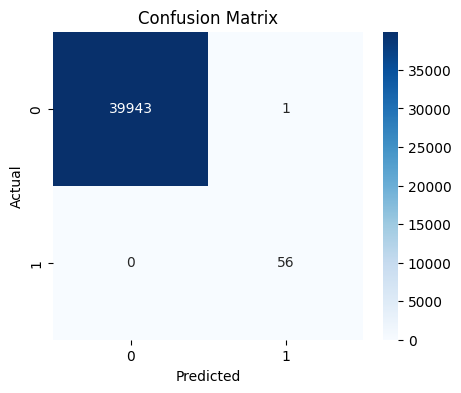

In [52]:
y_train_pred = grid.predict(x_train)
y_test_pred = grid.predict(x_test)


metrics = {
    "Train F1": f1_score(y_train, y_train_pred),
    "Test F1": f1_score(y_test, y_test_pred),
    "Train Recall": recall_score(y_train, y_train_pred),
    "Test Recall": recall_score(y_test, y_test_pred),
    "Train Precision": precision_score(y_train, y_train_pred),
    "Test Precision": precision_score(y_test, y_test_pred),
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_test_pred)
}

print(metrics)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

This result indicates that the model achieves perfect recall (1.0) on the test set which is critical in fraud detection tasks where missing fraudulent transactions is highly costly.
At the same time the very low number of false positives shows that the model does not excessively flag legitimate transactions as fraud.


In [53]:
# Save the final model and feature columns
Final_Model = grid.best_estimator_
joblib.dump(Final_Model, 'final_fraud_model.pkl')
joblib.dump(x.columns, 'feature_columns.pkl')

['feature_columns.pkl']